In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation, TriAnalyzer, UniformTriRefiner

In [2]:
def experiment_res(x, y):
    """an analytic function representing experiment results"""
    x = 2 * x
    r1 = np.sqrt((0.5 - x) ** 2 + (0.5 - y) ** 2)
    theta1 = np.arctan2(0.5 - x, 0.5 - y)
    r2 = np.sqrt((-x - 0.2) ** 2 + (-y - 0.2) ** 2)
    theta2 = np.arctan2(-x - 0.2, -y - 0.2)
    
    z = (
        4 * (np.exp((r1 / 10) ** 2) - 1) * 30 * np.cos(3 * theta1) +
        (np.exp((r2 / 10) ** 2) - 1) * 30 * np.cos(5 * theta2) +
        2 * (x ** 2 + y ** 2)
    )
    
    return (np.max(z) - z) / (np.max(z) - np.min(z))

In [3]:
# number of test data points, tested from 3 to 5000 for subdiv=3
n_test = 200

# number of recursive subdivisions of the initial mesh for smooth plots,
# values >3 might result in a very high number of triangles for the refine
# mesh: new triangles numbering = (4**subdiv)*ntri
subdiv = 3

# float > 0.0 adjusting the proportion of (invalid)
# initial triangles which will be masked out
# enter 0 for no mask
init_mask_frac = 0.0

# minimum circle ratio - border triangles with circle ratio
# below this will be masked if they touch a border
# suggested value 0.01; use -1 to keep all triangles
min_circle_ratio = 0.01

# random points
gen = np.random.RandomState(seed=100408030)
x_test = gen.uniform(-1.0, 1.0, size=n_test)
y_test = gen.uniform(-1.0, 1.0, size=n_test)
z_test = experiment_res(x_test, y_test)

In [4]:
# meshing with Delaunay triangulation
tri = Triangulation(x_test, y_test)
n_tri = tri.triangles.shape[0]

# some invalid data are masked out
mask_init = np.zeros(n_tri, dtype=bool)
masked_tri = gen.randint(0, n_tri, int(n_tri * init_mask_frac))
mask_init[masked_tri] = True
tri.set_mask(mask_init)

In [5]:
# improving the triangulation before high-res plots: removing flat triangles
# masking badly shaped triangles at the border of the triangular mesh
mask = TriAnalyzer(tri).get_flat_tri_mask(min_circle_ratio)
tri.set_mask(mask)

# refining the data
refiner = UniformTriRefiner(tri)
tri_refi, z_tri_refi = refiner.refine_field(z_test, subdiv=subdiv)

In [6]:
# analytical 'results' for comparison
z_expected = experiment_res(tri_refi.x, tri_refi.y)

# for the demo: loading the 'flat' triangles for plot
flat_tri = Triangulation(x_test, y_test)
flat_tri.set_mask(~mask)

In [7]:
# options for plots
plot_tri = True # plot of base triangulation
plot_masked_tri = True # plot of excessively flat excluded triangles
plot_refi_tri = True # plot of refined triangulation
plot_expected = True # plot of analytical function values for comparison

# graphical options for tricontouring
levels = np.arange(0.0, 1.0, 0.025)

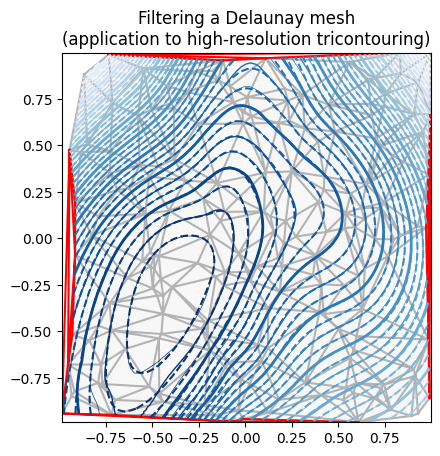

In [8]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_title("Filtering a Delaunay mesh\n(application to high-resolution tricontouring)")

# 1) plot of the refined (computed) data contours:
ax.tricontour(
    tri_refi, z_tri_refi, levels=levels, cmap="Blues",
    linewidths=[2.0, 0.5, 1.0, 0.5],
)

# 2) plot of the expected (analytical) data contours (dashed):
if plot_expected:
    ax.tricontour(tri_refi, z_expected, levels=levels, cmap="Blues", linestyles="--")

# 3) plot of the fine mesh on which interpolation was done:
if plot_refi_tri:
    ax.triplot(tri_refi, color="0.97")

# 4) plot of the initial 'coarse' mesh:
if plot_tri:
    ax.triplot(tri, color="0.7")

# 5) plot of the unvalidated triangles from naive Delaunay Triangulation:
if plot_masked_tri:
    ax.triplot(flat_tri, color="red")

plt.show()